MOUNTING DRIVE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


IMPORTING LIBRARIES FOR VGG16

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
import os
import matplotlib.pyplot as plt
import numpy as np

IMPORTING DATASETS

In [ ]:
#Importing the dataset as a generator
train_datagen = ImageDataGenerator(zoom_range=[0.8,0.8]).flow_from_directory(directory=os.path.join(os.getcwd(),'/content/drive/MyDrive/DR/DATA/train_images'),
                          target_size=(224,224),
                          #classes=['affected','normal'],
                          batch_size=5
                          )
train_datagen = ImageDataGenerator(zoom_range=[0.8,0.8]).flow_from_directory(directory=os.path.join(os.getcwd(),'/content/drive/MyDrive/DR/DATA/test_images'),
                          target_size=(224,224),
                          #classes=['affected','normal'],
                          batch_size=5
                          )

Found 2343 images belonging to 2 classes.
Found 2297 images belonging to 2 classes.


VISUALIZING THE DATASET

IMPORTING THE VGG16 MODEL

In [ ]:
#Importing pretrained VGG16,with Imagenet weights
from keras.applications.vgg16 import VGG16

vgg16 = VGG16()

model = Sequential()

553476096/553467096 [==============================] - 3s 0us/step


CONVERTING VGG16 MODEL INTO SEQUENTIAL MODEL

In [ ]:
#Converting VGG16 into Sequential model
for layer in vgg16.layers[:-1]:
    model.add(layer)

#Freezing all layers except last layer for transfer learning
for layer in model.layers:
    layer.trainable = False

ADDING LAYER

In [ ]:
#Adding custom softmax layer
model.add(Dense(2,activation='softmax'))

MODEL SUMMARY

In [ ]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       2

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,validation_split=0.25)

COMPILING MODEL

In [ ]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='Adam',
  metrics=['accuracy']
)

In [ ]:
train = '/content/drive/MyDrive/DR/DATA/train_images'
test = '/content/drive/MyDrive/DR/DATA/test_images'
training_set = train_datagen.flow_from_directory(train,
                                                 target_size = (224, 224),
                                                 batch_size = 5,
                                                 subset='training',
                                                 class_mode = 'categorical'
                                                 )


val_set = train_datagen.flow_from_directory(test,
                                            target_size = (224, 224),
                                            batch_size = 5,
                                            subset='validation',
                                            class_mode = 'categorical')


history = model.fit(
  
  training_set,steps_per_epoch=len(training_set),
  validation_data=val_set,validation_steps=len(val_set),
  epochs=2,
)

Found 1758 images belonging to 2 classes.
Found 573 images belonging to 2 classes.
Epoch 1/2
352/352 [==============================] - 823s 2s/step - loss: 0.3263 - accuracy: 0.8754 - val_loss: 0.3611 - val_accuracy: 0.8429
Epoch 2/2
352/352 [==============================] - 212s 601ms/step - loss: 0.2401 - accuracy: 0.9135 - val_loss: 0.2628 - val_accuracy: 0.9127


In [ ]:
import numpy as np
from keras.preprocessing import image
test_image = image.load_img('/content/drive/MyDrive/DR/DATA/test_images/normal/0/002c21358ce6.png', target_size = (224,224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model.predict(test_image)
training_set.class_indices
if result[0][0] == 1:
 print("DR")
else:
 print("Non DR")
 

Non DR


CONFUISON MATRIX

In [ ]:
import tensorflow as tf

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


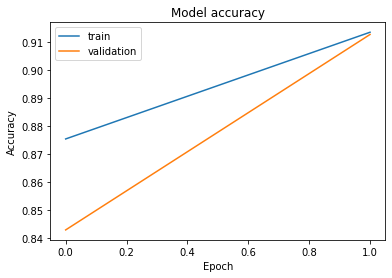

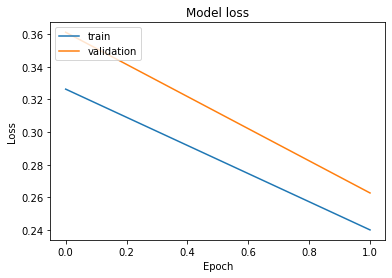

In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Save model

In [ ]:
#Saving the model
model.save('detector.h5')

LIME EXPLANATION

IMPORTING LIBRARIES

In [ ]:
%tensorflow_version 1.x
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

TensorFlow is already loaded. Please restart the runtime to change versions.
Notebook running: keras  2.7.0


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/DR/DATA/detector.h5')

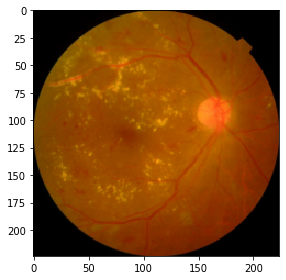

In [ ]:
Xi = skimage.io.imread("/content/drive/MyDrive/DR/DATA/train_images/affected/3/d035c2bd9104.png")
Xi = skimage.transform.resize(Xi, (224,224)) 
Xi = (Xi - 0.5)*2 #Inception pre-processing
skimage.io.imshow(Xi/2+0.5) # Show image before inception preprocessing

In [ ]:
np.random.seed(222)
preds = model.predict(Xi[np.newaxis,:,:,:])
#decode_predictions(preds)[0] #Top 5 classes

In [ ]:
from keras.applications.vgg16 import decode_predictions

In [ ]:
top_pred_classes = preds[0].argsort()[-5:][::-1]
top_pred_classes 

array([1, 0])

Extract super-pixels from image

In [ ]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

32

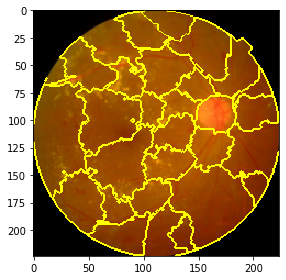

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

Create random perturbations

In [ ]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

The following function perturb_image perturbs the given image (img) based on a perturbation vector (perturbation) and predefined superpixels (segments).

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

perturbed image


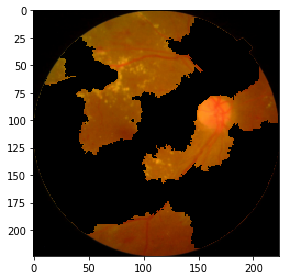

In [ ]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 2)

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [ ]:
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.01189719,  0.00524751, -0.01918902,  0.00021354, -0.00022827,
        0.0109611 ,  0.01117251,  0.02104694, -0.01460361, -0.00404107,
        0.00061382,  0.00593226,  0.00189091,  0.01335138,  0.00021734,
       -0.0029415 , -0.03588571,  0.00829435,  0.00822222, -0.01610398,
        0.0136432 , -0.00965828, -0.00530323,  0.02112189, -0.00716112,
       -0.00264535,  0.02088865,  0.02109879,  0.01102433,  0.0159116 ,
        0.01518542,  0.01479491])

In [ ]:
num_top_features = 6
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([30, 29, 26,  7, 27, 23])

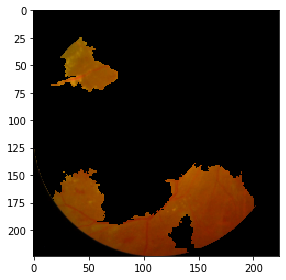

In [ ]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi/2+0.5,mask,superpixels) )